# 使用前，需要先导入需要的头文件

In [1]:
#include <iostream>

/*a workaround to solve cling issue*/
#include "../inc/macos_cling_workaround.hpp"
/*set libtorch path, load libs*/
#include "../inc/load_libtorch.hpp"
/*import custom defined macros*/
#include "../inc/custom_def.hpp"
/*import matplotlibcpp*/
#include "../inc/load_matplotlibcpp.hpp"
/*import opencv*/
#include "../inc/load_opencv.hpp"

/*import libtorch header file*/
#include <torch/torch.h>
#include <opencv2/opencv.hpp>
#include <cmath>

// Use (void) to silent unused warnings.
#define assertm(exp, msg) assert(((void)msg, exp))

In [2]:
class MyDataset : public torch::data::Dataset<MyDataset>
{
    private:
        torch::Tensor states_, labels_;

    public:
        explicit MyDataset(torch::Tensor states, torch::Tensor labels) 
            : states_(states),
              labels_(labels) {   };

        torch::data::Example<> get(size_t index) override {
            return {states_[index], labels_[index]};
        };

        torch::optional<size_t> size() const override {
            return states_.size(0);
        };
};

# 模型选择、欠拟合和过拟合

### 使用以下三阶多项式来生成训练和测试数据的标签

$y = 5 + 1.2x - 3.4 \frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \quad where \quad\epsilon \sim \mathcal{N} (0,0.01^2)$

In [3]:
constexpr int max_degree = 20;
constexpr int n_train = 100;
constexpr int n_test = 100;

//多项式系数
torch::Tensor true_w = torch::zeros(max_degree);
float temp[] = {5.0, 1.2, -3.4, 5.6};
memcpy(true_w.data_ptr(), temp, sizeof(temp));

//准备输入
torch::Tensor features = torch::randn({n_train + n_test, 1});
torch::Tensor poly_features = features.pow(torch::arange(max_degree)+1);

//生成输出
true_w = true_w.reshape({max_degree, 1});
printT(true_w);
torch::Tensor labels = poly_features.mm(true_w);
labels += torch::rand_like(labels) * 0.1;

true_w = 
 5.0000
 1.2000
-3.4000
 5.6000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
[ CPUFloatType{20,1} ]
<<--->>



In [4]:
printT(features.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    
  
printT(poly_features.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    

printT(labels.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    

features.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
 0.7540
-1.2295
[ CPUFloatType{2,1} ]
<<--->>

poly_features.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
Columns 1 to 8  0.7540   0.5686   0.4287   0.3233   0.2438   0.1838   0.1386   0.1045
 -1.2295   1.5118  -1.8587   2.2854  -2.8100   3.4549  -4.2480   5.2230

Columns 9 to 16  0.0788   0.0594   0.0448   0.0338   0.0255   0.0192   0.0145   0.0109
 -6.4219   7.8959  -9.7083  11.9367 -14.6765  18.0453 -22.1873  27.2800

Columns 17 to 20  0.0082   0.0062   0.0047   0.0035
-33.5417  41.2406 -50.7067  62.3455
[ CPUFloatType{2,20} ]
<<--->>

labels.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
  4.9044
 14.8287
[ CPUFloatType{2,1} ]
<<--->>



### 定义训练函数

In [5]:
std::vector<int> x;
std::vector<double> y;
std::vector<double> y_hat;

In [6]:
torch::Tensor train(torch::Tensor train_features, 
           torch::Tensor test_features, 
           torch::Tensor train_labels, 
           torch::Tensor test_labels,
           int num_epochs = 400,
           int batch_size = 10)
{
    assertm(train_features.dim() == 2, "train_features should have 2 dims");
    assertm(test_features.dim() == 2, "test_features should have 2 dims");
    
    auto train_data_set = MyDataset(train_features, train_labels).map(torch::data::transforms::Stack<>());
    auto test_data_set = MyDataset(test_features, test_labels).map(torch::data::transforms::Stack<>());

    auto train_data_loader = torch::data::make_data_loader<torch::data::samplers::RandomSampler>(
                                    std::move(train_data_set), 
                                    batch_size);

    auto test_data_loader = torch::data::make_data_loader<torch::data::samplers::RandomSampler>(
                                    std::move(test_data_set), 
                                    batch_size);

    int input_shape = train_features.size(1);
    torch::nn::Sequential net({{"fc", torch::nn::Linear(torch::nn::LinearOptions(input_shape, 1).bias(false))}});
    
//     net[0]->weight.data = torch::randn({input_shape, 1});
//     net->weight.normal_(0.0, 0.2);
    
    auto optimizer = torch::optim::SGD(net->parameters(), /*lr*/0.01);
    
        
    for (int epoch = 0; epoch < num_epochs; epoch++) 
    {
        torch::Tensor loss_values;
        if (epoch % 10 == 0) x.push_back(epoch);
        
        for (auto& batch : *train_data_loader) {
            auto data = batch.data;
            auto labels = batch.target;

//             optimizer.zero_grad();
            net->zero_grad();
            auto training_prediction = net->forward(data);
            loss_values = torch::mse_loss(training_prediction, labels);
            loss_values = loss_values.sum() / training_prediction.size(0);
            loss_values.backward(); 
            optimizer.step();
        }
        if (epoch % 10 == 0) 
//             y.push_back(loss_values.max().item<double>());
            y.push_back(loss_values.sum().item<double>());
        
        auto test_prediction = net->forward(test_features);
        auto test_loss_values = torch::mse_loss(test_prediction, test_labels);
        if (epoch % 10 == 0) 
//             y_hat.push_back(test_loss_values.max().item<double>());        
            y_hat.push_back(torch::sum(test_loss_values).item<double>() / test_prediction.size(0));        
        
        if (epoch % (num_epochs/10) == 0) {
        // Report the error with respect to y_training. 
        double max_loss = loss_values.max().item<double>();
        std::cout << "Epoch " << epoch 
            << ", max(loss_values) = " << max_loss << std::endl;
        }
    }
    
    std::cout << net->parameters() << std::endl;
    return net->parameters()[0];
}

In [7]:
auto train_data = 
    poly_features.index({torch::indexing::Slice(0, n_train, torch::indexing::None),
                         torch::indexing::Slice(0, 4, torch::indexing::None)});
auto train_label = 
    labels.index({torch::indexing::Slice(0, n_train, torch::indexing::None),
                         torch::indexing::Slice(0, 4, torch::indexing::None)});

auto test_data = 
    poly_features.index({torch::indexing::Slice(n_train, torch::indexing::None, torch::indexing::None),
                         torch::indexing::Slice(0, 4, torch::indexing::None)});
auto test_label = 
    labels.index({torch::indexing::Slice(n_train, torch::indexing::None, torch::indexing::None),
                         torch::indexing::Slice(0, 4, torch::indexing::None)});


printT(train_data.size(0));
printT(train_data.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    
printT(train_label.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    

train_data.size(0) = 
100
<<--->>

train_data.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
-1.2326e-01  1.5194e-02 -1.8728e-03  2.3085e-04
 1.8846e-02  3.5516e-04  6.6933e-06  1.2614e-07
[ CPUFloatType{2,4} ]
<<--->>

train_label.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
-0.5059
 0.1390
[ CPUFloatType{2,1} ]
<<--->>



### 训练并验证

In [8]:
auto w = train(train_data, test_data, train_label, test_label);

Epoch 0, max(loss_values) = 33.3615
Epoch 40, max(loss_values) = 2.58064e+16
Epoch 80, max(loss_values) = 3.13807e+28
Epoch 120, max(loss_values) = inf
Epoch 160, max(loss_values) = inf
Epoch 200, max(loss_values) = inf
Epoch 240, max(loss_values) = inf
Epoch 280, max(loss_values) = inf
Epoch 320, max(loss_values) = nan
Epoch 360, max(loss_values) = nan
-nan -nan -nan -nan
[ CPUFloatType{1,4} ]


In [9]:
//true_w
// = {5.0, 1.2, -3.4, 5.6};

w = w.reshape({4,1});
printT(train_label[0]);
printT(train_data[0].reshape({1,4}).mm(w));

printT(test_label[3]);
printT(test_data[3].reshape({1,4}).mm(w));

train_label[0] = 
 5.4560
[ CPUFloatType{1} ]
<<--->>

train_data[0].reshape({1,4}).mm(w) = 
 5.0456
[ CPUFloatType{1,1} ]
<<--->>

test_label[3] = 
-1.3893
[ CPUFloatType{1} ]
<<--->>

test_data[3].reshape({1,4}).mm(w) = 
-1.2793
[ CPUFloatType{1,1} ]
<<--->>



### 训练结果可视化

In [10]:
plt::semilogy(x, y, "b");
plt::semilogy(x, y_hat, "r");

plt::title("loss(r:test  b:train)");
plt::legend();
plt::save("./loss.png"); 
plt::show();

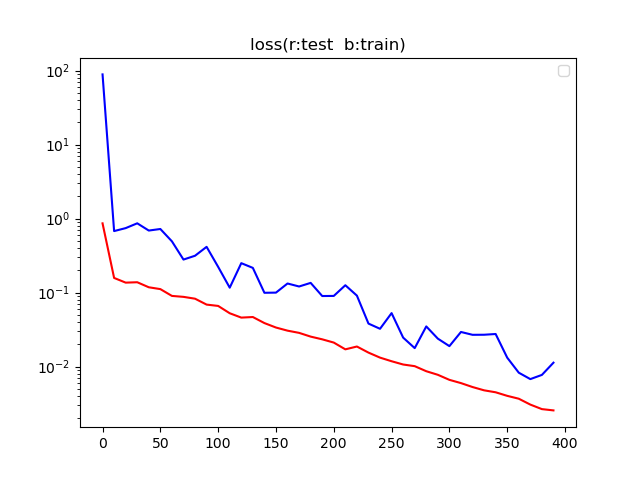

In [11]:
auto img1 = im::image("./loss.png");
img1  

# 欠拟合

In [12]:
auto train_data = 
    poly_features.index({torch::indexing::Slice(0, n_train, torch::indexing::None),
                         torch::indexing::Slice(0, 2, torch::indexing::None)});
auto train_label = 
    labels.index({torch::indexing::Slice(0, n_train, torch::indexing::None),
                         torch::indexing::Slice(0, 2, torch::indexing::None)});

auto test_data = 
    poly_features.index({torch::indexing::Slice(n_train, torch::indexing::None, torch::indexing::None),
                         torch::indexing::Slice(0, 2, torch::indexing::None)});
auto test_label = 
    labels.index({torch::indexing::Slice(n_train, torch::indexing::None, torch::indexing::None),
                         torch::indexing::Slice(0, 2, torch::indexing::None)});


printT(train_data.size(0));
printT(train_data.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    
printT(train_label.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    

train_data.size(0) = 
100
<<--->>

train_data.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
 0.8101  0.6562
-1.2146  1.4752
[ CPUFloatType{2,2} ]
<<--->>

train_label.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
  5.4560
 14.0353
[ CPUFloatType{2,1} ]
<<--->>



In [13]:
std::vector <int>().swap(x);
std::vector <double>().swap(y);
std::vector <double>().swap(y_hat);

auto w = train(train_data, test_data, train_label, test_label);

Epoch 0, max(loss_values) = 53.1338
Epoch 40, max(loss_values) = 21.3282
Epoch 80, max(loss_values) = 197.99
Epoch 120, max(loss_values) = 11.5253
Epoch 160, max(loss_values) = 202.93
Epoch 200, max(loss_values) = 21.1204
Epoch 240, max(loss_values) = 24.6509
Epoch 280, max(loss_values) = 17.1833
Epoch 320, max(loss_values) = 30.9816
Epoch 360, max(loss_values) = 22.1492
 -6.1948  24.7249
[ CPUFloatType{1,2} ]


In [14]:
//true_w
// = {5.0, 1.2, -3.4, 5.6};

w = w.reshape({2,1});
printT(train_label[0]);
printT(train_data[0].reshape({1,2}).mm(w));

printT(test_label[3]);
printT(test_data[3].reshape({1,2}).mm(w));

train_label[0] = 
 5.4560
[ CPUFloatType{1} ]
<<--->>

train_data[0].reshape({1,2}).mm(w) = 
 11.2067
[ CPUFloatType{1,1} ]
<<--->>

test_label[3] = 
-1.3893
[ CPUFloatType{1} ]
<<--->>

test_data[3].reshape({1,2}).mm(w) = 
 6.5931
[ CPUFloatType{1,1} ]
<<--->>



In [15]:
plt::semilogy(x, y, "b");
plt::semilogy(x, y_hat, "r");

plt::title("loss(r:test  b:train)");
plt::legend();
plt::save("./loss_underfit.png"); 
plt::show();

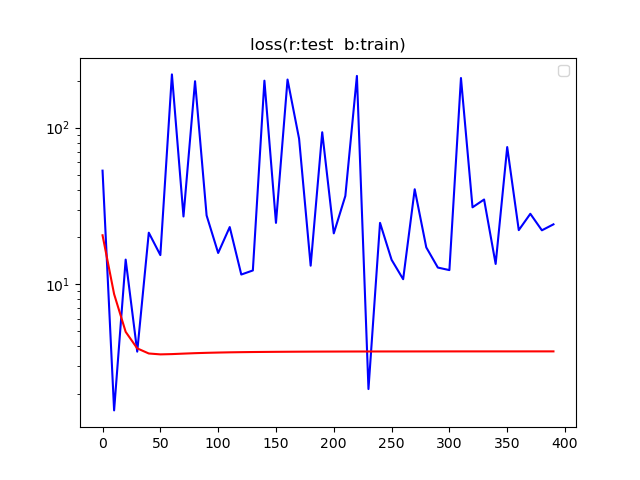

In [16]:
auto img2 = im::image("./loss_underfit.png");
img2

# 过拟合

In [17]:
auto train_data = 
    poly_features.index({torch::indexing::Slice(0, n_train, torch::indexing::None),
                         torch::indexing::Slice(0, max_degree, torch::indexing::None)});
auto train_label = 
    labels.index({torch::indexing::Slice(0, n_train, torch::indexing::None),
                         torch::indexing::Slice(0, max_degree, torch::indexing::None)});

auto test_data = 
    poly_features.index({torch::indexing::Slice(n_train, torch::indexing::None, torch::indexing::None),
                         torch::indexing::Slice(0, max_degree, torch::indexing::None)});
auto test_label = 
    labels.index({torch::indexing::Slice(n_train, torch::indexing::None, torch::indexing::None),
                         torch::indexing::Slice(0, max_degree, torch::indexing::None)});


printT(train_data.size(0));
printT(train_data.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    
printT(train_label.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    

train_data.size(0) = 
100
<<--->>

train_data.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
Columns 1 to 8  0.8101   0.6562   0.5316   0.4306   0.3488   0.2826   0.2289   0.1854
 -1.2146   1.4752  -1.7917   2.1762  -2.6431   3.2103  -3.8992   4.7358

Columns 9 to 16  0.1502   0.1217   0.0986   0.0799   0.0647   0.0524   0.0424   0.0344
 -5.7520   6.9862  -8.4853  10.3061 -12.5175  15.2034 -18.4657  22.4280

Columns 17 to 20  0.0279   0.0226   0.0183   0.0148
-27.2404  33.0856 -40.1849  48.8076
[ CPUFloatType{2,20} ]
<<--->>

train_label.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
  5.4560
 14.0353
[ CPUFloatType{2,1} ]
<<--->>



In [18]:
std::vector <int>().swap(x);
std::vector <double>().swap(y);
std::vector <double>().swap(y_hat);

auto w = train(train_data, test_data, train_label, test_label);

Epoch 0, max(loss_values) = nan
Epoch 40, max(loss_values) = nan
Epoch 80, max(loss_values) = nan
Epoch 120, max(loss_values) = nan
Epoch 160, max(loss_values) = nan
Epoch 200, max(loss_values) = nan
Epoch 240, max(loss_values) = nan
Epoch 280, max(loss_values) = nan
Epoch 320, max(loss_values) = nan
Epoch 360, max(loss_values) = nan
-nan -nan -nan -nan -nan -nan -nan -nan -nan -nan -nan -nan -nan -nan -nan -nan -nan -nan -nan -nan
[ CPUFloatType{1,20} ]


In [19]:
//true_w
// = {5.0, 1.2, -3.4, 5.6};

w = w.reshape({max_degree,1});
printT(train_label[0]);
printT(train_data[0].reshape({1,max_degree}).mm(w));

printT(test_label[3]);
printT(test_data[3].reshape({1,max_degree}).mm(w));

train_label[0] = 
 5.4560
[ CPUFloatType{1} ]
<<--->>

train_data[0].reshape({1,max_degree}).mm(w) = 
-nan
[ CPUFloatType{1,1} ]
<<--->>

test_label[3] = 
-1.3893
[ CPUFloatType{1} ]
<<--->>

test_data[3].reshape({1,max_degree}).mm(w) = 
-nan
[ CPUFloatType{1,1} ]
<<--->>



In [20]:
plt::semilogy(x, y, "b");
plt::semilogy(x, y_hat, "r");

plt::title("loss_overfit(r:test  b:train)");
plt::legend();
plt::save("./loss_overfit.png"); 
plt::show();

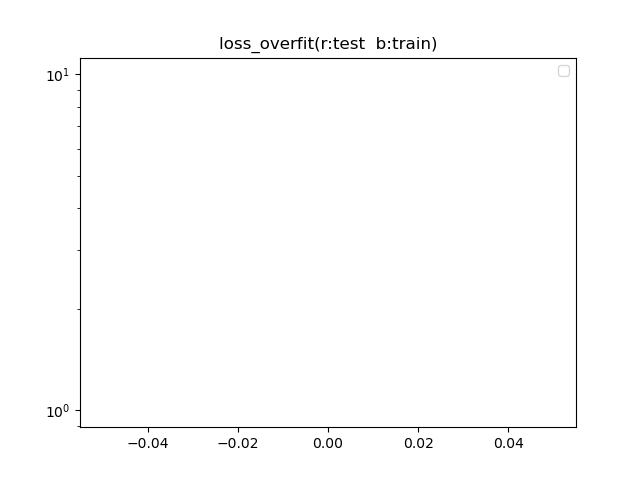

In [21]:
auto img2 = im::image("./loss_overfit.png");
img2